In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [63]:
import gzip
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
from nfp.preprocessing.crystal_preprocessor import PymatgenPreprocessor
from pymatgen.core import Structure
from tqdm.auto import tqdm

tqdm.pandas()

inputs_dir = Path("/projects/rlmolecule/pstjohn/crystal_inputs/")
volrelax_dir = Path("/projects/rlmolecule/pstjohn/volume_relaxation_outputs/")

vol_energy_file = Path(volrelax_dir, "20220504_volume_relaxed_energy.csv.gz")

vol_energy = pd.read_csv(vol_energy_file)
# batt_energy = pd.read_csv(Path(batt_energy_file))
# icsd_energy = pd.read_csv(icsd_energy_file)

data = pd.read_pickle(Path(inputs_dir, "20220603_scaled_inputs.p"))
data['type'] = data.type.astype('category')

data['volperatom'] = data['volume'] / data['num_sites']
data['scaled_input_volperatom'] = data['volperatom'] * data['scale_factor']**3

max_distance = data['inputs'].apply(lambda x: x['distance'].max())
data = data[(max_distance < 100) & (data.scaled_input_volperatom < 30)]  # drop some problematic icsd + volrelaxed structures
data.shape

(151478, 10)

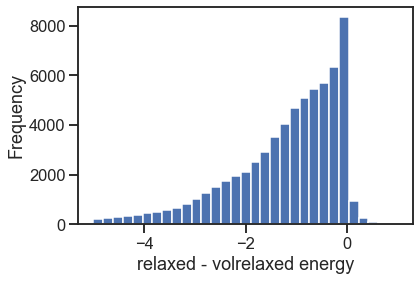

In [10]:
pivoted_data = data[data.type != 'icsd'].pivot(index='id', columns='type', values='energyperatom')
(pivoted_data.relax - pivoted_data.vol).plot.hist(range=(-5, 1), bins=31)
plt.xlabel('relaxed - volrelaxed energy')

relax_issues = pivoted_data[(pivoted_data.relax - pivoted_data.vol) > 0]
data = data[~(data.id.isin(relax_issues.index) & (data.type == 'relax'))]

In [11]:
vol_energy['hit_upper_bound'] = vol_energy.volume > (vol_energy.dls_volume * 1.95 - 1)
print(vol_energy['hit_upper_bound'].sum())

to_drop = data[(data.type == 'vol') & data.id.isin(vol_energy[vol_energy['hit_upper_bound']].id)]
data['hit_upper_bound'] = data.index.isin(to_drop.index)

8438


In [12]:
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element

In [13]:
composition = data.composition.progress_apply(lambda x: pd.Series(Composition(x).as_dict())).fillna(0.)

  0%|          | 0/148635 [00:00<?, ?it/s]

In [14]:
X = composition[data.type.isin(['icsd', 'relax'])].values
y = data[data.type.isin(['icsd', 'relax'])].energyperatom.values * X.sum(1)

In [15]:
from sklearn.linear_model import HuberRegressor

reg = HuberRegressor(max_iter=1000)
reg.fit(X, y)

HuberRegressor(max_iter=1000)

In [16]:
y_vol = data[data.type.isin(['icsd', 'relax'])].volperatom.values * X.sum(1)

reg_vol = HuberRegressor(max_iter=1000)
reg_vol.fit(X, y_vol)

HuberRegressor(max_iter=1000)

In [17]:
## calculate predicted energies from linear model

data['reg_energyperatom'] = reg.predict(composition) / composition.sum(1)
data['reg_volperatom'] = reg_vol.predict(composition) / composition.sum(1)

In [19]:
data['residual_energy'] = data['energyperatom'] - data['reg_energyperatom']
data['residual_volume'] = data['volperatom'] - data['reg_volperatom']

In [44]:
energy_outliers = (data.residual_energy < -2) | (data.residual_energy > 6)
volume_outliers = (data.residual_volume < -20) | (data.residual_volume > 50)

In [45]:
(energy_outliers | volume_outliers).sum()

2758

In [46]:
data_subset = data[~(energy_outliers | volume_outliers)]

In [47]:
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

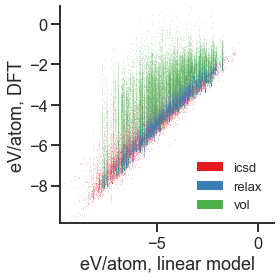

In [48]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

artist = dsshow(data_subset[~data_subset.hit_upper_bound],
       ds.Point('reg_energyperatom', 'energyperatom'),
       ds.count_cat('type'),       
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(-10, 1), y_range=(-10, 1), ax=ax)

ax.set_xlabel('eV/atom, linear model')
ax.set_ylabel('eV/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()

plt.tight_layout()
plt.savefig('energy_regression.png')

(-2.0, 6.0)

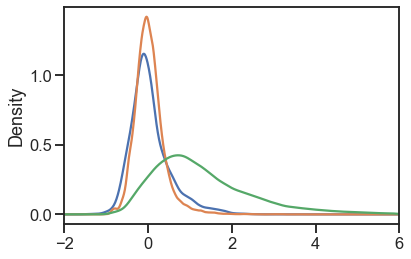

In [49]:
data_subset[data_subset.type == 'icsd'].residual_energy.plot.kde()
data_subset[data_subset.type == 'relax'].residual_energy.plot.kde()
data_subset[data_subset.type == 'vol'].residual_energy.plot.kde()

plt.xlim([-2, 6])

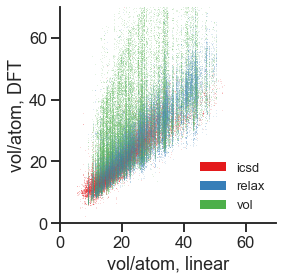

In [50]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

artist = dsshow(data_subset[~data_subset.hit_upper_bound],
       ds.Point('reg_volperatom', 'volperatom'),
       ds.count_cat('type'),
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(0, 70), y_range=(0, 70), ax=ax)

ax.set_xlabel('vol/atom, linear')
ax.set_ylabel('vol/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()

plt.tight_layout()
plt.savefig('volume_regression.png')

(-20.0, 60.0)

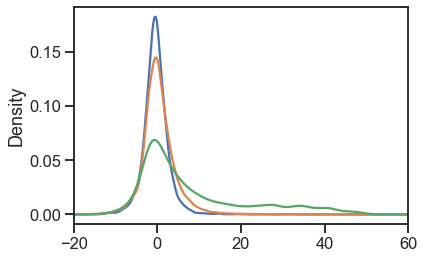

In [53]:
data_subset[data_subset.type == 'icsd'].residual_volume.plot.kde()
data_subset[data_subset.type == 'relax'].residual_volume.plot.kde()
data_subset[data_subset.type == 'vol'].residual_volume.plot.kde()

plt.xlim([-20, 60])

In [54]:
data_trimmed = data_subset[['id', 'type', 'composition', 'num_sites', 'inputs', 'hit_upper_bound', 'energyperatom', 'volperatom', 'scaled_input_volperatom']]
# data_trimmed.to_pickle(Path(inputs_dir, "20220603_outliers_removed.p"))